In [23]:
# Imports
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rich.progress import track
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import nibabel as nib
import cv2

import wandb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import torchcde

In [24]:
# read in tabular data
d1_d2 = pd.read_csv('../tadpole_challenge/TADPOLE_D1_D2.csv')
cols = ['RID', 'PTID', 'EXAMDATE', 'VISCODE', 'DX_bl', 'AGE', 'PTGENDER', 'PTETHCAT', 'PTRACCAT',
        'APOE4', 'MMSE', 'CDRSB', 'RAVLT_immediate', 'RAVLT_learning',
        'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ', 'ADAS13',
        'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal',
        'Fusiform', 'MidTemp', 'ICV', 'IMAGEUID_UCSFFSX_11_02_15_UCSFFSX51_08_01_16']
d1_d2 = d1_d2[cols]

mri_subset = pd.read_csv('../tadpole_challenge/tadpole_sample_2_21_2022.csv')
cols = ['Image Data ID', 'Subject', 'Group', 'Visit', 'Acq Date']
mri_subset = mri_subset[cols]
mri_subset['Image Data ID'] = mri_subset['Image Data ID'].str[1:].astype(int)
mri_subset
#d1_d2

/Users/aashish/anaconda3/envs/neural_ode/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (471,473,474,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,569,570,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,599,601,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,624,625,626,627,628,629,630,631,632,633,634,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,7

,Image Data ID,Subject,Group,Visit,Acq Date
0,138890,002_S_1280,CN,4,3/25/2008
1,234659,002_S_1280,CN,10,5/04/2011
2,60056,002_S_1280,CN,1,2/13/2007
3,171124,002_S_1280,CN,8,2/18/2010
4,419623,002_S_1280,CN,30,3/14/2014
...,...,...,...,...,...
76,150177,002_S_0295,CN,8,5/22/2009
77,291867,002_S_0295,CN,10,5/13/2010
78,64025,002_S_0295,CN,4,5/25/2007
79,241350,002_S_0295,CN,26,6/02/2011


In [25]:
d1_d2_mri = d1_d2[d1_d2['PTID'].isin(mri_subset.Subject.unique())]
d1_d2_mri.reset_index(drop=True, inplace=True)
mri_subset.reset_index(drop=True, inplace=True)
print(d1_d2_mri.shape)
print(mri_subset.shape)
for i in range(d1_d2_mri.shape[0]):
    print(d1_d2_mri.loc[i, 'PTID'], end=',')
    print(d1_d2_mri.loc[i, 'EXAMDATE'], end=',')
    print(d1_d2_mri.loc[i, 'IMAGEUID_UCSFFSX_11_02_15_UCSFFSX51_08_01_16'], end=',')
    print(mri_subset.loc[mri_subset['Image Data ID'] == d1_d2_mri.loc[i, 'IMAGEUID_UCSFFSX_11_02_15_UCSFFSX51_08_01_16'], 'Acq Date'])

(139, 26)
(81, 5)
002_S_0295,2006-05-09,118671,73    4/18/2006
Name: Acq Date, dtype: object
002_S_0295,2006-11-02,118692,75    11/02/2006
Name: Acq Date, dtype: object
002_S_0295,2007-05-25,64025,78    5/25/2007
Name: Acq Date, dtype: object
002_S_0295,2008-08-04,123685,74    7/23/2008
Name: Acq Date, dtype: object
002_S_0295,2009-05-07,150177,76    5/22/2009
Name: Acq Date, dtype: object
002_S_0295,2010-05-13,291867,77    5/13/2010
Name: Acq Date, dtype: object
002_S_0295,2011-06-02,241350,79    6/02/2011
Name: Acq Date, dtype: object
002_S_0295,2012-05-10,308078,80    5/10/2012
Name: Acq Date, dtype: object
002_S_0413,2006-05-08,118673,67    5/02/2006
Name: Acq Date, dtype: object
002_S_0413,2006-11-14,118695,70    11/15/2006
Name: Acq Date, dtype: object
002_S_0413,2007-06-01,60008,68    6/01/2007
Name: Acq Date, dtype: object
002_S_0413,2008-07-31,120917,66    7/31/2008
Name: Acq Date, dtype: object
002_S_0413,2009-04-30,149740,69    5/04/2009
Name: Acq Date, dtype: object
002_S_0

In [26]:
print(sorted(mri_subset.Subject.unique()))
print(sorted(d1_d2_mri.PTID.unique()))

['002_S_0295', '002_S_0413', '002_S_0685', '002_S_0729', '002_S_0782', '002_S_1070', '002_S_1155', '002_S_1261', '002_S_1268', '002_S_1280']
['002_S_0295', '002_S_0413', '002_S_0685', '002_S_0729', '002_S_0782', '002_S_1070', '002_S_1155', '002_S_1261', '002_S_1268', '002_S_1280']


In [27]:
mri_merge = pd.merge(d1_d2_mri, mri_subset, how='outer', left_on='IMAGEUID_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', right_on='Image Data ID')
mri_merge.to_csv('temp.csv')

In [28]:
# read in image data
base_dir = '/Users/aashish/OneDrive - Central Bucks School District/adni_tadpole/ADNI/'
subjects = glob.glob(base_dir + '*')
images = [glob.glob(subject + '/*/*/*/*') for subject in subjects]
images

[['/Users/aashish/OneDrive - Central Bucks School District/adni_tadpole/ADNI/002_S_0782/MPR__GradWarp__B1_Correction__N3__Scaled_2/2006-08-14_09_39_47.0/I118669/ADNI_002_S_0782_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001114355178_S17835_I118669.nii',
  '/Users/aashish/OneDrive - Central Bucks School District/adni_tadpole/ADNI/002_S_0782/MPR-R__GradWarp__B1_Correction__N3__Scaled/2008-06-18_07_55_00.0/I112184/ADNI_002_S_0782_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20080702103252324_S51854_I112184.nii',
  '/Users/aashish/OneDrive - Central Bucks School District/adni_tadpole/ADNI/002_S_0782/MPR__GradWarp__B1_Correction__N3__Scaled/2008-10-17_09_33_59.0/I124718/ADNI_002_S_0782_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20081031093818145_S57626_I124718.nii',
  '/Users/aashish/OneDrive - Central Bucks School District/adni_tadpole/ADNI/002_S_0782/MPR__GradWarp__B1_Correction__N3__Scaled/2007-04-11_08_07_06.0/I60456/ADNI_002_S_0782_MR_MPR__GradWarp__B1_Correction__N3

In [29]:
id_dict = {}
for i, subject in enumerate(images):
    for j, image in enumerate(subject):
        image_id = int(image.split('/')[-2][1:])
        id_dict[image_id] = image

In [30]:
def encode(df):
    df['DX_bl'] = df['DX_bl'].astype('category').cat.codes
    df['PTGENDER'] = df['PTGENDER'].astype('category').cat.codes
    df['PTRACCAT'] = df['PTRACCAT'].astype('category').cat.codes
    df['PTETHCAT'] = df['PTETHCAT'].astype('category').cat.codes
    df.replace(to_replace='bl', value='b00', inplace=True)
    df['Months'] = df['Months'].str[1:].astype(int)
    return df

In [31]:
mri_merge['Patient ID'] = mri_merge['PTID'].combine_first(mri_merge['Subject'])
mri_merge['Image ID'] = mri_merge['IMAGEUID_UCSFFSX_11_02_15_UCSFFSX51_08_01_16'].combine_first(mri_merge['Image Data ID'])
mri_merge.drop(['PTID', 'Subject', 'Image Data ID', 'IMAGEUID_UCSFFSX_11_02_15_UCSFFSX51_08_01_16'], axis=1, inplace=True)
mri_merge['image_path'] = mri_merge['Image ID'].map(id_dict)

In [32]:
dx_bl = [mri_merge[mri_merge['Patient ID'] == i]['DX_bl'].dropna().mode().tolist()[0] for i in mri_merge['Patient ID'].unique()]
dx_bl = dict(zip(mri_merge['Patient ID'].unique(), dx_bl))
mri_merge['DX_bl'] = mri_merge['Patient ID'].map(dx_bl)

age = [mri_merge[mri_merge['Patient ID'] == i]['AGE'].dropna().mode().tolist()[0] for i in mri_merge['Patient ID'].unique()]
age = dict(zip(mri_merge['Patient ID'].unique(), age))
mri_merge['AGE'] = mri_merge['Patient ID'].map(age)

apoe = [mri_merge[mri_merge['Patient ID'] == i]['APOE4'].dropna().mode().tolist()[0] for i in mri_merge['Patient ID'].unique()]
apoe = dict(zip(mri_merge['Patient ID'].unique(), apoe))
mri_merge['APOE'] = mri_merge['Patient ID'].map(apoe)

gender = [mri_merge[mri_merge['Patient ID'] == i]['PTGENDER'].dropna().mode().tolist()[0] for i in mri_merge['Patient ID'].unique()]
gender = dict(zip(mri_merge['Patient ID'].unique(), gender))
mri_merge['PTGENDER'] = mri_merge['Patient ID'].map(gender)

ptraccat = [mri_merge[mri_merge['Patient ID'] == i]['PTRACCAT'].dropna().mode().tolist()[0] for i in mri_merge['Patient ID'].unique()]
ptraccat = dict(zip(mri_merge['Patient ID'].unique(), ptraccat))
mri_merge['PTRACCAT'] = mri_merge['Patient ID'].map(ptraccat)

ptethcat = [mri_merge[mri_merge['Patient ID'] == i]['PTETHCAT'].dropna().mode().tolist()[0] for i in mri_merge['Patient ID'].unique()]
ptethcat = dict(zip(mri_merge['Patient ID'].unique(), ptethcat))
mri_merge['PTETHCAT'] = mri_merge['Patient ID'].map(ptethcat)

num_to_code = {
    1.0:'bl',   3.0:'m06',  4.0:'m12',  5.0:'m18',
    6.0:'m24',  8.0:'m36',  10.0:'m48', 26.0:'m60',
    28.0:'m72', 30.0:'m84', 32.0:'m96', 34.0:'m108'
}

mri_merge['Visit'] = mri_merge['Visit'].map(num_to_code)
mri_merge['Months'] = mri_merge['VISCODE'].combine_first(mri_merge['Visit'])
mri_merge.drop(['Visit', 'VISCODE'], axis=1, inplace=True)

In [33]:
mri_merge = encode(mri_merge)
mri_merge.to_csv('first_clean.csv')

In [34]:
cols = ['Patient ID', 'Image ID', 'image_path', 'Months', 'ADAS13', 'DX_bl', 'AGE', 'PTGENDER', 'PTETHCAT', 'PTRACCAT', 'APOE4', 'MMSE', 'CDRSB', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']
sub_dfs = [df[cols].sort_values(by='Months').reset_index(drop=True) for _, df in mri_merge.groupby('Patient ID')]
sub_dfs[0]

,Patient ID,Image ID,image_path,Months,ADAS13,DX_bl,AGE,PTGENDER,PTETHCAT,PTRACCAT,...,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
0,002_S_0295,118671,/Users/aashish/OneDrive - Central Bucks School...,0,4.00,0,84.8,1,1,0,...,3.0,23.0769,0.0,39130.0,7068.0,1076350.0,3619.0,16561.0,19829.0,1633860.0
1,002_S_0295,118692,/Users/aashish/OneDrive - Central Bucks School...,6,6.33,0,84.8,1,1,0,...,2.0,16.6667,0.0,39101.0,6896.0,1089680.0,3662.0,18041.0,19825.0,1645300.0
2,002_S_0295,64025,/Users/aashish/OneDrive - Central Bucks School...,12,5.67,0,84.8,1,1,0,...,2.0,14.2857,0.0,40554.0,6894.0,1085210.0,3572.0,17386.0,19917.0,1651500.0
3,002_S_0295,,NaN,18,NaN,0,84.8,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,002_S_0295,123685,/Users/aashish/OneDrive - Central Bucks School...,24,5.67,0,84.8,1,1,0,...,2.0,16.6667,0.0,42423.0,6839.0,1067480.0,3855.0,18159.0,19269.0,1650520.0
5,002_S_0295,,NaN,30,NaN,0,84.8,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,002_S_0295,150177,/Users/aashish/OneDrive - Central Bucks School...,36,6.67,0,84.8,1,1,0,...,2.0,22.2222,0.0,43862.0,6674.0,1053480.0,3620.0,17964.0,19482.0,1646810.0
7,002_S_0295,,NaN,42,NaN,0,84.8,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,002_S_0295,291867,/Users/aashish/OneDrive - Central Bucks School...,48,8.00,0,84.8,1,1,0,...,2.0,15.3846,0.0,44051.0,6753.0,1032350.0,3760.0,16549.0,18326.0,1613900.0
9,002_S_0295,,NaN,54,NaN,0,84.8,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
sub_dfs = [df[df['ADAS13'].notna() & df['image_path'].notna()] for df in sub_dfs]

In [36]:
for i, sub_df in enumerate(sub_dfs):
    if sub_df.isnull().values.any():
        print('sub num: ', i)
        print(sub_df)
        

sub num:  2
    Patient ID Image ID                                         image_path  \
0   002_S_0685   118680  /Users/aashish/OneDrive - Central Bucks School...   
1   002_S_0685    86020  /Users/aashish/OneDrive - Central Bucks School...   
2   002_S_0685    74174  /Users/aashish/OneDrive - Central Bucks School...   
4   002_S_0685   120994  /Users/aashish/OneDrive - Central Bucks School...   
6   002_S_0685   161974  /Users/aashish/OneDrive - Central Bucks School...   
8   002_S_0685   291874  /Users/aashish/OneDrive - Central Bucks School...   
12  002_S_0685   326600  /Users/aashish/OneDrive - Central Bucks School...   

    Months  ADAS13  DX_bl   AGE  PTGENDER  PTETHCAT  PTRACCAT  ...  \
0        0    6.67      0  89.6         0         1         0  ...   
1        6   17.00      0  89.6         0         1         0  ...   
2       12    9.00      0  89.6         0         1         0  ...   
4       24    9.67      0  89.6         0         1         0  ...   
6       36   

In [37]:
sub_dfs[0].to_csv('example_sub.csv')

In [38]:
split_len = len(sub_dfs)
rand_idx = list(range(split_len))
random.shuffle(rand_idx)

train_list = [sub_dfs[i] for i in rand_idx[:int(split_len * 0.7)]]
val_list = [sub_dfs[i] for i in rand_idx[int(split_len * 0.7):int(split_len * 0.85)]]
test_list = [sub_dfs[i] for i in rand_idx[int(split_len * 0.85):]]

## Feature Extraction

In [39]:
path = '/Users/aashish/Desktop/science_fair/Research/adni/src/neural_cde.ipynb'
os.environ['WANDB_NOTEBOOK_NAME'] = path
wandb.login()

True

In [40]:
# set seeds
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)

In [41]:
class ADNIDataset(Dataset):
    def __init__(self, df_list, sequence_len):
        self.df_list = df_list
        self.sequence_len = sequence_len
        self.seq_list = self.preprocess()
        self.target = self.seq_list[0].columns[-1]
        self.features = self.seq_list[0].columns[3:-1]
        self.img = self.seq_list[0].columns[2]

    def __len__(self):
        return len(self.seq_list)

    def __getitem__(self, idx):
        X = torch.tensor(self.seq_list[idx][self.features].values)
        y = torch.tensor(self.seq_list[idx][self.target].values[-1])
                
        imgs = self.img_process(self.seq_list[idx][self.img].values)
        imgs = torch.tensor(imgs).unsqueeze(1)

        return {
            'X': X.type(torch.double),
            'imgs': imgs.type(torch.double),
            'y': y.type(torch.double),
        }

    def preprocess(self): 
        cleaned_df_list = [] 
        for df in self.df_list: 
            df_clean = df.dropna() ## TODO - try to remove this
            df_clean = self.shift(df) 
            df_clean = df_clean.reset_index(drop=True) 
            cleaned_df_list.append(df_clean) 

        seq_list = [] 
        for df in cleaned_df_list: 
            for i in range(len(df)): 
                if i >= self.sequence_len -1: 
                    i_start = i - self.sequence_len + 1 
                    seq = df.iloc[i_start:i+1] 
                else:
                    seq = pd.concat([df.iloc[[0]]] * (self.sequence_len - i - 1),
                                    ignore_index=True)
                    seq = pd.concat([seq, df.iloc[:i+1]], ignore_index=True)
                seq_list.append(seq.reset_index(drop=True))
        return seq_list

    def img_process(self, img_list):
        img_data_list = []
        for img_path in img_list:
            if str(img_path) != 'nan':
                img = nib.load(str(img_path))
                img_slice = np.random.randint(0, 166)
                if img.shape[0] == 256:
                    img_data = img.get_fdata().transpose((2, 1, 0))
                    img_data = img_data[:, ::-1, ::-1]
                    pad_value = (img_data.shape[0] - 166) / 2
                    img_data = img_data[int(pad_value):int(pad_value + 166), :, :][img_slice]
                else:
                    img_data = img.get_fdata()
                    pad_value = (img_data.shape[0] - 166) / 2
                    img_data = img_data[int(pad_value):int(pad_value + 166), :, :][img_slice]
            else:
                img_data = np.nan
            img_data_list.append(img_data)
        print(np.array(img_data_list).shape)
        return np.array(img_data_list).astype(np.float32)

    def shift(self, x: pd.DataFrame):
        x['Months(t+1)'] = x['Months'].shift(-1)
        x['ADAS(t+1)'] = x['ADAS13'].shift(-1)
        x = x.iloc[:-1]
        return x

In [42]:
class CDEFunc(nn.Module):
    def __init__(self, input_channels, hidden_channels):
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        self.linear1 = nn.Linear(hidden_channels, 128)
        self.linear2 = nn.Linear(128, input_channels * hidden_channels)
    
    def forward(self, t, z):
        z = self.linear1(z)
        z = z.relu()
        z = self.linear2(z)
        z = z.tanh()
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z

class NeuralCDE(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, interpolation="cubic"):
        super(NeuralCDE, self).__init__()

        self.cdefunc = CDEFunc(input_channels, hidden_channels)
        self.initial = nn.Linear(input_channels, hidden_channels)
        self.readout = nn.Linear(hidden_channels, output_channels)
        self.interpolation = interpolation 

    def forward(self, coeffs):
        if self.interpolation == 'cubic':
            X = torchcde.CubicSpline(coeffs)
        elif self.interpolation == 'linear':
            X = torchcde.LinearSpline(coeffs)
        else:
            raise ValueError("Only 'linear' and 'cubic' interpolation methods are implemented.")
        
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)
        
        adjoint_params = tuple(self.cdefunc.parameters()) + (coeffs,)
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.cdefunc,
                              t=X.interval,
                              adjoint_params=adjoint_params)

        z_T = z_T[:, 1]
        pred_y = self.readout(z_T)
        return pred_y

In [43]:
class ADNIModel(nn.Module):
    def __init__(self, input_size, hidden_size, img_out_size, eff_name):
        super(ADNIModel, self).__init__()
        self.img_out_size = img_out_size
        self.ncde = NeuralCDE(input_size, hidden_size, 1)
        self.extractor = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            EfficientNet.from_pretrained(f'efficientnet-{eff_name}'),
            nn.Linear(1000, self.img_out_size),
        )

    def forward(self, tabs, imgs):
        # imgs = imgs.permute((1, 0, 2, 3, 4))
        features = torch.zeros(imgs.shape[0], SEQUENCE_LEN, self.img_out_size)
        for i in range(SEQUENCE_LEN):
            features[:, i, :] = self.extractor(imgs[:, i, :, :, :])
        print(tabs.shape)
        tabs = torch.concat([tabs, features], dim=-1)
        coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(tabs)
        out = self.ncde(coeffs)
        return out 

In [44]:
# hyperparameters
SEQUENCE_LEN = 3
BATCH_SIZE = 8
LEARNING_RATE = 5e-4
HIDDEN_SIZE = 10
IMG_OUT_SIZE = 5
EPOCHS = 1
WB = False

train_dataset = ADNIDataset(train_list, SEQUENCE_LEN)
val_dataset = ADNIDataset(val_list, SEQUENCE_LEN)
test_dataset = ADNIDataset(test_list, SEQUENCE_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/var/folders/jv/4n9t0z4x1hq19bqjlw2x7f840000gn/T/ipykernel_2592/4066682246.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Months(t+1)'] = x['Months'].shift(-1)
/var/folders/jv/4n9t0z4x1hq19bqjlw2x7f840000gn/T/ipykernel_2592/4066682246.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['ADAS(t+1)'] = x['ADAS13'].shift(-1)


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ADNIModel(input_size=28, hidden_size=HIDDEN_SIZE, img_out_size=IMG_OUT_SIZE, eff_name='b1')
model.double();

Loaded pretrained weights for efficientnet-b1


In [46]:
def train_reg(model, device, train_loader, val_loader, test_loader, epochs, wb):
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.L1Loss()

    print('start of training loop')

    train_losses = []
    val_losses = []

    if wb:
        wandb.init(project='adni_img_series_node', entity='ashcher51')
        wandb.watch(model)
    
    for epoch in track(range(epochs), description='Training...'):
        model.train()

        train_loss = 0
        train_rmse = 0
        train_rsq = 0
        count = 0

        for batch in train_loader:
            optimizer.zero_grad()        

            X, imgs, y = batch['X'].to(device), batch['imgs'].to(device), batch['y'].to(device)
            out = model(X, imgs)
            loss = criterion(out, y.view(-1, 1))

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * y.size(0)
            predicted = out.cpu().detach().numpy()
            actual = y.cpu().detach().numpy()

            train_rmse += mean_squared_error(actual, predicted, squared=False)
            train_rsq += r2_score(actual, predicted)
            count += 1

        train_loss /= len(train_loader.sampler)
        train_losses.append(train_loss)

        train_rmse /= count
        train_rsq /= count

        if wb:
            wandb.log({'train_loss': train_loss, 'train_rmse': train_rmse, 'train_rsq': train_rsq})
        
        # Validation
        model.eval()
        val_loss = 0
        val_rmse = 0
        val_rsq = 0
        count = 0

        for batch in val_loader:
            optimizer.zero_grad()
            X, imgs, y = batch['X'].to(device), batch['imgs'].to(device), batch['y'].to(device)
            out = model(X, imgs)
            loss = criterion(out, y.view(-1, 1))

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * y.size(0)
            predicted = out.cpu().detach().numpy()
            actual = y.cpu().detach().numpy()

            train_rmse += mean_squared_error(actual, predicted, squared=False)
            train_rsq += r2_score(actual, predicted)
            count += 1
        
        val_loss /= len(val_dataloader.sampler)
        val_losses.append(val_loss)

        val_rmse /= count
        val_rsq /= count

        if wb:
            wandb.log({'train_loss': train_loss, 'train_rmse': train_rmse, 'train_rsq': train_rsq})

        print(
            "\n",
            "\n",
            f"Epoch {epoch+1}/{epochs}\n",
            f"Train loss: {train_loss:.4f}\n",
            f"Valid loss: {val_loss:.4f}\n",
            "\n",
            f"Train RMSE: {train_rmse:.4f}\n",
            f"Valid RMSE: {val_rmse:.4f}\n",
            "\n",
            f"Train R^2: {train_rsq:.4f}\n",
            f"Valid R^2: {val_rsq:.4f}\n",
        )
    
    # Test
    model.eval()

    test_rmse = 0
    test_rsq = 0
    count = 0

    for batch in test_loader:
        X, img, y = batch['X'].to(device), batch['imgs'].to(device), batch['y'].to(device)

        out = model(X, img)
        loss = criterion(out, y.view(-1, 1))

        test_predicted = out.cpu().detach().numpy()
        test_actual = y.cpu().detach().numpy()

        test_rmse += mean_squared_error(test_actual, test_predicted, squared=False)
        test_rsq += r2_score(test_actual, test_predicted)

        count += 1

    test_rmse /= count
    test_rsq /= count
    
    if wb:
        wandb.log({'test_rmse': test_rmse, 'test_rsq': test_rsq})
    
    print(
        "\n",
        "\n",
        "\n",
        "Training Finished!\n",
        f"Test RMSE: {test_rmse:.4f}...\n",
        f"Test R^2: {test_rsq:.4f}...\n",
        f"Predictions: {test_predicted}\n",
        f"Actual: {test_actual}\n\n",
    )

    print(f'\nlen of predicted: {len(test_predicted)}\n')
    print('Loss Curves: ')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(list(range(epochs)), train_losses, label='train')
    plt.plot(list(range(epochs)), val_losses, label='valid')
    plt.legend()
    plt.show()

    plt.scatter(test_actual, test_predicted)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    torch.save(model.state_dict(), 'model.pt')

Output()

start of training loop


(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
torch.Size([7, 3, 23])

 
 
 Training Finished!
 Test RMSE: 11675.9909...
 Test R^2: -7522605.8069...
 Predictions: [[11425.59398385]
 [14119.86434401]
 [13494.97194843]
 [15569.36228024]
 [10816.21558107]
 [ 9035.16948256]
 [-1673.78380915]]
 Actual: [ 3.   17.    9.    9.67 14.33 10.    7.  ]



len of predicted: 7

Loss Curves: 


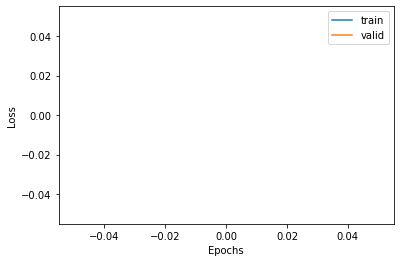

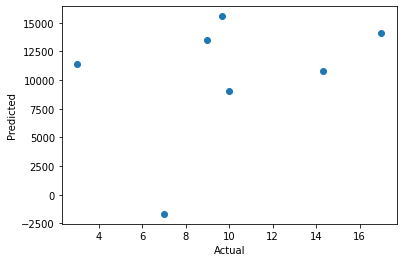

In [48]:
train_reg(model, device, train_dataloader, val_dataloader, test_dataloader, 0, WB)